In [1]:
%load_ext autoreload
%autoreload 2
%reset -f

import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import matplotlib.pyplot as plt

import src.visualisation as vis
from src.StocksDataset import StocksDataset
from models.LSTM import LSTM

torch.manual_seed(123)

In [2]:
path = "./datasets/aapl.csv"

df = pd.read_csv(path, parse_dates=["Date"])
df = df.sort_values("Date", ascending=True).reset_index(drop=True)
df.head(3)

,Date,Open,High,Low,Close,Volume
0,2015-08-12,28.1325,28.8550,27.4075,28.8100,406373600
1,2015-08-13,29.0100,29.1000,28.6350,28.7875,193630560
2,2015-08-14,28.5800,29.0775,28.5025,28.9900,171505480


In [3]:
feature_cols = ["Open", "High", "Low", "Close", "Volume"]

cols_to_standardize = ["Open", "High", "Low", "Close", "Volume"]
split_idx = int(0.8 * len(df))
df_train, df_test = df.iloc[:split_idx].copy(), df.iloc[split_idx:].copy()

scalers = {}
for col in cols_to_standardize:
    scaler = StandardScaler()
    df_train[col] = scaler.fit_transform(df_train[[col]])
    df_test[col]  = scaler.transform(df_test[[col]])
    scalers[col] = scaler

df_scaled = pd.concat([df_train, df_test], axis=0)
df_scaled.head(3)

,Date,Open,High,Low,Close,Volume
0,2015-08-12,-1.033069,-1.024753,-1.041984,-1.020833,4.585699
1,2015-08-13,-1.016578,-1.020204,-1.018650,-1.021255,1.174720
2,2015-08-14,-1.024659,-1.020622,-1.021169,-1.017453,0.819981


In [4]:
lookback_days = 30
future_days = 5
window_size = lookback_days+future_days

data_np = df_scaled[feature_cols].values.astype(np.float32)

X, y = [], []
for i in range(len(data_np) - lookback_days - future_days + 1):
    X.append(data_np[i:i+lookback_days])
    y.append(data_np[i+lookback_days:i+lookback_days+future_days, 3])
X, y = np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)
print(X.shape, y.shape)

(2480, 30, 5) (2480, 5)


In [5]:
n = len(X)
split = int(0.8 * n)

train_dataset = StocksDataset(X[:split], y[:split])
test_dataset  = StocksDataset(X[split:], y[split:])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

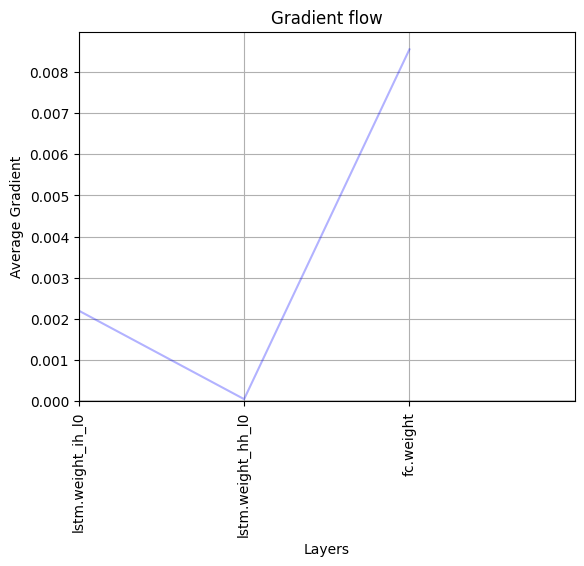

Epoch [5/10], Train loss: 0.010554, Validation loss: 0.033265
Epoch [10/10], Train loss: 0.009381, Validation loss: 0.033962


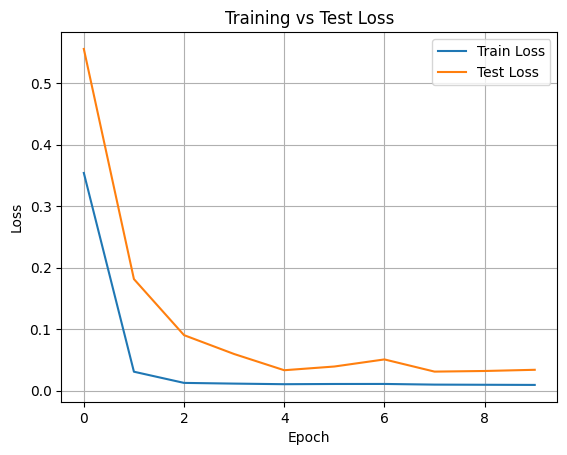

In [6]:
device = torch.device("mps" if torch.mps.is_available() else "cpu")

n_epochs = 10
plot_gradients = True

model = LSTM(
    input_size=5,
    hidden_size=512,
    num_layers=1,
    dropout=0.0,
    pred_days=future_days
).to(device)
# model = nn.Transformer(
#     nhead=16,
#     num_encoder_layers=12,
#     batch_first=True
# ).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
train_losses = []
val_losses = []

for epoch in range(n_epochs):
    # ---- Train ----
    model.train()
    total_loss = 0
    _batch_counter = 0 # used to show gradients only once
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        total_loss += loss.item()
        loss = criterion(outputs, y_batch)
        loss.backward()
        if epoch == 0 and plot_gradients and _batch_counter == 0:
            vis.plot_grad_flow(model.named_parameters())
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        _batch_counter += 1

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    scheduler.step()

    # ---- Test ----
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(test_loader)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}], Train loss: {avg_train_loss:.6f}, Validation loss: {avg_val_loss:.6f}")


plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Test Loss")
plt.legend()
plt.grid(True)
plt.show()

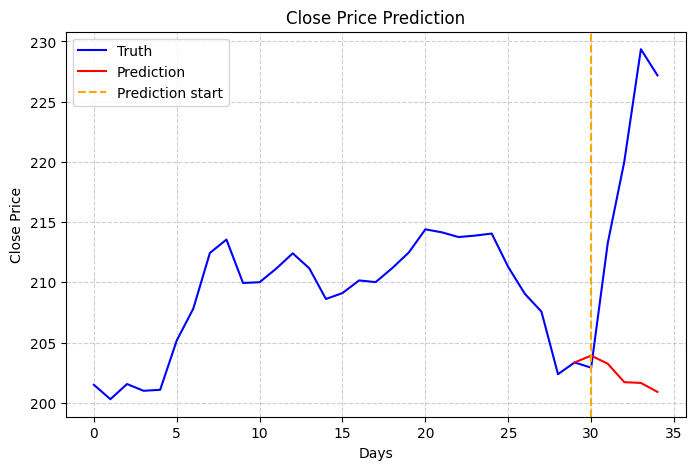

In [7]:
n_images = 1
for n in range(1, n_images+1):
    end_of_window = -window_size*(n-1)
    visualisation_set = data_np[-window_size*n:None if end_of_window == 0 else end_of_window]

    context = torch.tensor(visualisation_set[:lookback_days], dtype=torch.float32).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(context).cpu().numpy().reshape(-1, 1)

    vis_close_scaled = visualisation_set[:, 3].reshape(-1, 1)
    vis_close = scalers["Close"].inverse_transform(vis_close_scaled).squeeze()

    pred_close = scalers["Close"].inverse_transform(outputs).squeeze()

    vis.plot_predictions(vis_close, pred_close)